In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
import torch
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
import numpy as np
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)
import PIL.Image
Image.MAX_IMAGE_PIXELS = None
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from collections import Counter
import multiprocessing
num_of_workers = multiprocessing.cpu_count()

# cuda visibile devices 0, 1
os.environ["CUDA_VISIBLE_DEVICES"] =  "0, 1"

# Load the data
df = pd.read_csv('kevin__data_exploration_taxonomy.csv')

def filter_existing_images(df, image_dir):
    existing_files = []
    for file_name in df['file_name']:
        if os.path.exists(os.path.join(image_dir, str(file_name))):
            existing_files.append(file_name)
    
    return df[df['file_name'].isin(existing_files)].reset_index(drop=True)

image_dir = "/home/trkosire/Factorynet/hackathon/all_images/" 
df = filter_existing_images(df, image_dir)

# set random seed 
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
momentum = 0.9
learning_rates = [0.01]
learning_rate_decay = 0.0001
weight_decay = 0.0002
num_epochs = 15
batch_sizes = [64]
early_stopping_patience = 5 

MINORITY_THRESHOLD = 1000
# Standard augmentation for majority classes
standard_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# More aggressive augmentation for minority classes
aggressive_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_dir):
        self.df = df
        self.image_paths = [os.path.join(image_dir, str(file_name)) for file_name in df['file_name']]
        self.labels = df['target'].values
        
        # Determine minority classes
        class_counts = df['target'].value_counts()
        self.minority_classes = class_counts[class_counts < MINORITY_THRESHOLD].index.tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        
        # Apply appropriate transform based on the class
        if label in self.minority_classes:
            image = aggressive_transform(image)
        else:
            image = standard_transform(image)
        
        return image, label

dataset = CustomDataset(df, image_dir)

X = dataset
y = dataset.labels

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

def undersample(X, y):
    class_counts = Counter(y)
    min_class_count = min(class_counts.values())
    
    undersampled_indices = []
    for class_label in class_counts:
        class_indices = np.where(y == class_label)[0]
        undersampled_indices.extend(np.random.choice(class_indices, min_class_count, replace=False))
    
    return [X[i] for i in undersampled_indices], y[undersampled_indices]

# Perform undersampling on the training data
X_train_undersampled, y_train_undersampled = undersample(X_train, y_train)

# Create new datasets
train_data_undersampled = CustomDataset(pd.DataFrame({'file_name': [x.image_paths[0].split('/')[-1] for x in X_train_undersampled], 'target': y_train_undersampled}), image_dir)
val_data = CustomDataset(pd.DataFrame({'file_name': [x.image_paths[0].split('/')[-1] for x in X_val], 'target': y_val}), image_dir)
test_data = CustomDataset(pd.DataFrame({'file_name': [x.image_paths[0].split('/')[-1] for x in X_test], 'target': y_test}), image_dir)

# Model setup
dropout_rate = 0.5

class ModifiedResNet152(torch.nn.Module):
    def __init__(self, original_model, dropout_rate):
        super(ModifiedResNet152, self).__init__()
        self.features = torch.nn.Sequential(*list(original_model.children())[:-1])
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.fc = torch.nn.Linear(original_model.fc.in_features, 11)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

from torchvision.models import ResNet152_Weights
original_model = torchvision.models.resnet152(weights=ResNet152_Weights.DEFAULT)
model = ModifiedResNet152(original_model, dropout_rate)
model = torch.nn.DataParallel(model)
model = model.to(device)

# Focal Loss setup
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)): 
            self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list): 
            self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)
            input = input.transpose(1, 2)
            input = input.contiguous().view(-1, input.size(2))
        target = target.view(-1, 1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = logpt.exp()

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt)**self.gamma * logpt
        if self.size_average: 
            return loss.mean()
        else: 
            return loss.sum()

# Loss function and optimizer setup
num_classes = df['target'].nunique()  
alpha = torch.ones(num_classes, device=device)
class_counts = Counter(y_train_undersampled)
total_samples = sum(class_counts.values())
for i in range(num_classes):
    alpha[i] = 1 - (class_counts[i] / total_samples)
criterion = FocalLoss(gamma=2, alpha=alpha)

def mixup_data(x, y, alpha=1.0, device=device):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_and_evaluate(model, train_loader, val_loader, test_loader, optimizer, scheduler, num_epochs, early_stopping_patience):
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    train_losses = []
    val_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            labels = labels.type(torch.LongTensor)
            images, labels = images.to(device), labels.to(device)
            images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=1.0, device=device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                labels = labels.type(torch.LongTensor)
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Evaluate on test set
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                labels = labels.type(torch.LongTensor)
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_test_loss = test_loss / len(test_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        test_losses.append(avg_test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered")
                break

    # Restore best model
    model.load_state_dict(best_model_state)
    return model, best_val_loss, train_losses, val_losses, test_losses

# Hyperparameter tuning
best_hyperparams = {'learning_rate': None, 'batch_size': None, 'val_loss': float('inf')}
best_model_state = None
best_losses = None

results = []

for lr in learning_rates:
    for bs in batch_sizes:
        print(f"Training with learning rate: {lr}, batch size: {bs}")

        # Create dataloaders
        train_loader = DataLoader(train_data_undersampled, batch_size=bs, shuffle=True, num_workers=num_of_workers)
        val_loader = DataLoader(val_data, batch_size=bs, shuffle=False,num_workers=num_of_workers)
        test_loader = DataLoader(test_data, batch_size=bs, shuffle=False, num_workers=num_of_workers)

        # Initialize model
        model = ModifiedResNet152(torchvision.models.resnet152(weights=ResNet152_Weights.DEFAULT), dropout_rate=0.5)
        model = model.to(device)

        # Initialize optimizer and scheduler
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        # Train and evaluate
        model, val_loss, train_losses, val_losses, test_losses = train_and_evaluate(
            model, train_loader, val_loader, test_loader, optimizer, scheduler, num_epochs, early_stopping_patience
        )

        # Store results
        results.append({
            'lr': lr,
            'bs': bs,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'test_losses': test_losses
        })

        # Update best hyperparameters if current combination is better
        if val_loss < best_hyperparams['val_loss']:
            best_hyperparams['learning_rate'] = lr
            best_hyperparams['batch_size'] = bs
            best_hyperparams['val_loss'] = val_loss
            best_model_state = model.state_dict()
            best_losses = (train_losses, val_losses, test_losses)

print(f"Best Hyperparameters: Learning Rate = {best_hyperparams['learning_rate']}, Batch Size = {best_hyperparams['batch_size']}")

# Save the best overall model
torch.save(best_model_state, 'best_model.pth')

# Save the losses for the best model
np.save('best_model_losses.npy', best_losses)

# Save all results
np.save('all_results.npy', results)

# Plot learning curves for the best model
train_losses, val_losses, test_losses = best_losses

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color = 'red')
plt.plot(val_losses, label='Validation Loss', color = 'blue')
plt.plot(test_losses, label='Test Loss', color = 'green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Learning Curves (LR={best_hyperparams["learning_rate"]}, BS={best_hyperparams["batch_size"]})')
plt.legend()
plt.savefig('learning_curves.png')
plt.close()

# Create plots for each hyperparameter combination
for result in results:
    plt.figure(figsize=(10, 5))
    plt.plot(result['train_losses'], label='Training Loss', color = 'red')
    plt.plot(result['val_losses'], label='Validation Loss', color = 'blue')
    plt.plot(result['test_losses'], label='Test Loss', color = 'green')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Learning Curves (LR={result["lr"]}, BS={result["bs"]})')
    plt.legend()
    plt.savefig(f'learning_curves_lr{result["lr"]}_bs{result["bs"]}.png')
    plt.close()

def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            labels = labels.type(torch.LongTensor)
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels)

# Load the best model
best_model = ModifiedResNet152(torchvision.models.resnet152(weights=ResNet152_Weights.DEFAULT), dropout_rate=0.5)
best_model = best_model.to(device)
best_model.load_state_dict(torch.load('best_model.pth'))

# Create test DataLoader
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Get predictions
predictions, true_labels = evaluate_model(best_model, test_loader, device)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate per-class metrics
class_precision, class_recall, class_f1, _ = precision_recall_fscore_support(true_labels, predictions, average=None)

# Print per-class metrics
for i in range(len(class_precision)):
    print(f"Class {i}:")
    print(f"  Precision: {class_precision[i]:.4f}")
    print(f"  Recall: {class_recall[i]:.4f}")
    print(f"  F1 Score: {class_f1[i]:.4f}")

# Create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.close()

# Print class distribution after undersampling
print("\nClass distribution after undersampling:")
class_counts = Counter(y_train_undersampled)
total_samples = sum(class_counts.values())
for class_label, count in sorted(class_counts.items()):
    print(f"Class {class_label}: {count} samples ({count/total_samples:.2%})")

# You might want to add more analysis or visualization here
# For example, you could plot the distribution of classes after undersampling

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution After Undersampling')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.savefig('class_distribution_after_undersampling.png')
plt.close()

print("\nTraining completed. Results and visualizations have been saved.")

In [1]:
from torchvision.models import resnet18, ResNet18_Weights
import torch
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
import numpy as np
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)
import PIL.Image
Image.MAX_IMAGE_PIXELS = None
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# cuda visibile devices 0, 1
os.environ["CUDA_VISIBLE_DEVICES"] =  "0, 1"

In [2]:
# Load the data
df = pd.read_csv('kevin__data_exploration_taxonomy.csv')

In [3]:
# df.to_csv('kevin__data_exploration_taxonomy.csv', index=False)

In [3]:
def filter_existing_images(df, image_dir):
    existing_files = []
    for file_name in df['file_name']:
        if os.path.exists(os.path.join(image_dir, str(file_name))):
            existing_files.append(file_name)
    
    return df[df['file_name'].isin(existing_files)].reset_index(drop=True)

image_dir = "/home/trkosire/Factorynet/hackathon/all_images/" 
df = filter_existing_images(df, image_dir)


In [4]:
df

,label,x1,y1,height,width,source,file_name,analyzed_labels,taxonomy_label,target
0,railway grinding machine,0.0,0.0,720.0,720.0,user,0_1711591656377_railway grinding machine.png,"['railway', 'grinding', 'machine']",materials,4
1,rail grinder,0.0,0.0,720.0,720.0,user,1_1711591656377_rail grinder.png,"['rail', 'grinder']",materials,4
2,rail grinder with worker,0.0,0.0,720.0,720.0,user,2_1711591656377_rail grinder with worker.png,"['rail', 'grinder', 'with', 'worker']",materials,4
3,railway grinding machine with worker,0.0,0.0,720.0,720.0,user,3_1711591656377_railway grinding machine with ...,"['railway', 'grinding', 'machine', 'with', 'wo...",materials,4
4,worker,0.0,0.0,720.0,720.0,user,4_1711591656377_worker.png,['worker'],maintenance,3
...,...,...,...,...,...,...,...,...,...,...
23288,minibar t,0.0,0.0,2660.0,4000.0,wikimedia,23296_1711580020679_minibar t.png,"['minibar', 't']",machines,2
23289,rail clamp,0.0,0.0,605.0,907.0,user,23297_1711581093292_rail clamp.png,"['rail', 'clamp']",materials,4
23290,patrol rail fastening,0.0,0.0,2304.0,3456.0,wikimedia,23298_1711581093292_patrol rail fastening.png,"['patrol', 'rail', 'fastening']",safety,8
23291,drill bit,0.0,0.0,651.0,907.0,user,23299_1711566352395_drill bit.png,"['drill', 'bit']",machines,2


In [5]:
import multiprocessing

num_workers = multiprocessing.cpu_count()

print(f"Number of workers: {num_workers}")

Number of workers: 48


In [6]:
# set random seed 
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # Hyperparameters
momentum = 0.9
learning_rates = 0.01 # best learning rate is 0.01
learning_rate_decay = 0.0001
weight_decay = 0.0002
num_epochs = 15
batch_sizes = 64 # best batch size is 128
early_stopping_patience = 5 


MINORITY_THRESHOLD = 1000
# Standard augmentation for majority classes
standard_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# More aggressive augmentation for minority classes
aggressive_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# create a dataset for each cluster
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_dir):
        self.df = df
        self.image_paths = [os.path.join(image_dir, str(file_name)) for file_name in df['file_name']]
        self.labels = df['target'].values
        
        # Determine minority classes
        class_counts = df['target'].value_counts()
        self.minority_classes = class_counts[class_counts < MINORITY_THRESHOLD].index.tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        
        # Apply appropriate transform based on the class
        if label in self.minority_classes:
            image = aggressive_transform(image)
        else:
            image = standard_transform(image)
        
        return image, label

    
dataset = CustomDataset(df, image_dir)

X = dataset
y = dataset.labels

# # Get image paths and labels for oversampling
# X = dataset.image_paths  # Using image paths as a placeholder for X
# y = dataset.labels

# from imblearn.over_sampling import RandomOverSampler
# # Apply Random Over Sampler
# ros = RandomOverSampler(random_state=42)
# X_resampled, y_resampled = ros.fit_resample([[x] for x in X], y)  # X needs to be 2D
# X_resampled = [x[0] for x in X_resampled]  # Flatten the list

# X = X_resampled
# y = y_resampled



In [7]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

In [8]:
# save X_train, X_val, X_test, y_train, y_val, y_test to disk
# torch.save(X_train, 'X_train.pt')
# torch.save(X_val, 'X_val.pt')
# torch.save(X_test, 'X_test.pt')
# torch.save(y_train, 'y_train.pt')
# torch.save(y_val, 'y_val.pt')
# torch.save(y_test, 'y_test.pt')

# Load the data
# X_train = torch.load('X_train.pt')
# X_val = torch.load('X_val.pt')
# X_test = torch.load('X_test.pt')
# y_train = torch.load('y_train.pt')
# y_val = torch.load('y_val.pt')
# y_test = torch.load('y_test.pt')


# train_data = ConcatDataset([X_train])
# val_data = ConcatDataset([X_val])
# test_data = ConcatDataset([X_test])

train_data = CustomDataset(pd.DataFrame({'file_name': X_train, 'target': y_train}), image_dir)
val_data = CustomDataset(pd.DataFrame({'file_name': X_val, 'target': y_val}), image_dir)
test_data = CustomDataset(pd.DataFrame({'file_name': X_test, 'target': y_test}), image_dir)


In [9]:
# print the distribution of the classes in the train, val and test set

from collections import Counter

# Assuming y_train, y_val, and y_test are your label arrays for each set

# Count occurrences of each class
train_distribution = Counter(y_train)
val_distribution = Counter(y_val)
test_distribution = Counter(y_test)

# Print distributions
print("Train set class distribution:")
for class_label, count in sorted(train_distribution.items()):
    print(f"Class {class_label}: {count}")

print("\nValidation set class distribution:")
for class_label, count in sorted(val_distribution.items()):
    print(f"Class {class_label}: {count}")

print("\nTest set class distribution:")
for class_label, count in sorted(test_distribution.items()):
    print(f"Class {class_label}: {count}")

# Calculate percentages
total_train = sum(train_distribution.values())
total_val = sum(val_distribution.values())
total_test = sum(test_distribution.values())

print("\nPercentage distribution:")
print("Class\tTrain\tVal\tTest")
for class_label in sorted(set(train_distribution.keys()) | set(val_distribution.keys()) | set(test_distribution.keys())):
    train_percent = train_distribution[class_label] / total_train * 100
    val_percent = val_distribution[class_label] / total_val * 100
    test_percent = test_distribution[class_label] / total_test * 100
    print(f"{class_label}\t{train_percent:.2f}%\t{val_percent:.2f}%\t{test_percent:.2f}%")

Train set class distribution:
Class 0: 2301
Class 1: 2300
Class 2: 2301
Class 3: 2300
Class 4: 2300
Class 5: 2301
Class 6: 2300
Class 7: 2300
Class 8: 2300
Class 9: 2300
Class 10: 2301

Validation set class distribution:
Class 0: 767
Class 1: 767
Class 2: 766
Class 3: 767
Class 4: 767
Class 5: 767
Class 6: 767
Class 7: 767
Class 8: 767
Class 9: 767
Class 10: 766

Test set class distribution:
Class 0: 766
Class 1: 767
Class 2: 767
Class 3: 767
Class 4: 767
Class 5: 766
Class 6: 767
Class 7: 767
Class 8: 767
Class 9: 767
Class 10: 767

Percentage distribution:
Class	Train	Val	Test
0	9.09%	9.09%	9.08%
1	9.09%	9.09%	9.09%
2	9.09%	9.08%	9.09%
3	9.09%	9.09%	9.09%
4	9.09%	9.09%	9.09%
5	9.09%	9.09%	9.08%
6	9.09%	9.09%	9.09%
7	9.09%	9.09%	9.09%
8	9.09%	9.09%	9.09%
9	9.09%	9.09%	9.09%
10	9.09%	9.08%	9.09%


In [ ]:



# Model setup
dropout_rate = 0.5

class ModifiedResNet152(torch.nn.Module):
    def __init__(self, original_model, dropout_rate):
        super(ModifiedResNet152, self).__init__()
        self.features = torch.nn.Sequential(*list(original_model.children())[:-1])
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.fc = torch.nn.Linear(original_model.fc.in_features, 11)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

from torchvision.models import ResNet152_Weights
original_model = torchvision.models.resnet152(weights=ResNet152_Weights.DEFAULT)
model = ModifiedResNet152(original_model, dropout_rate)
model = torch.nn.DataParallel(model)
model = model.to(device)

# due to class imbalance we will use weighted cross entropy loss
class_counts = df['target'].value_counts()
class_weights = np.zeros(len(class_counts))
for class_index, count in class_counts.items():
    class_weights[class_index] = 1.0 / count
class_weights = class_weights / class_weights.sum()
class_weights = torch.FloatTensor(class_weights).to(device)

class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)): 
            self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list): 
            self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = logpt.exp()

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt)**self.gamma * logpt
        if self.size_average: 
            return loss.mean()
        else: 
            return loss.sum()
        
        
# Loss function and optimizer
num_classes = df['target'].nunique()  
alpha = torch.ones(num_classes, device=device)
alpha = alpha * (1 - class_weights)  
criterion = FocalLoss(gamma=2, alpha=alpha)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rates, momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=learning_rate_decay)



def mixup_data(x, y, alpha=1.0, device=device):
    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    '''Compute the mixup loss'''
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)



def train_and_evaluate(model, train_loader, val_loader, test_loader, optimizer, scheduler, num_epochs, early_stopping_patience):
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    train_losses = []
    val_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            labels = labels.type(torch.LongTensor)
            images, labels = images.to(device), labels.to(device)
            images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=1.0, device=device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                labels = labels.type(torch.LongTensor)
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Evaluate on test set
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                labels = labels.type(torch.LongTensor)
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_test_loss = test_loss / len(test_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        test_losses.append(avg_test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered")
                break

    # Restore best model
    model.load_state_dict(best_model_state)
    return model, best_val_loss, train_losses, val_losses, test_losses

# Hyperparameter tuning
best_hyperparams = {'learning_rate': None, 'batch_size': None, 'val_loss': float('inf')}
best_model_state = None
best_losses = None

results = []

# for lr in learning_rates:
#     for bs in batch_sizes:
print(f"Training with learning rate: {learning_rates}, batch size: {batch_sizes}")

# Create dataloaders
train_loader = DataLoader(train_data, batch_size=batch_sizes, shuffle=True, num_workers= num_workers)
val_loader = DataLoader(val_data, batch_size=batch_sizes, shuffle=False, num_workers = num_workers)
test_loader = DataLoader(test_data, batch_size=batch_sizes, shuffle=False, num_workers=num_workers)

# Initialize model
model = ModifiedResNet152(torchvision.models.resnet152(weights=ResNet152_Weights.DEFAULT), dropout_rate=0.5)
model = model.to(device)

# Initialize optimizer and scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rates, momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train and evaluate
model, val_loss, train_losses, val_losses, test_losses = train_and_evaluate(
    model, train_loader, val_loader, test_loader, optimizer, scheduler, num_epochs, early_stopping_patience
)

# Store results
results.append({
    'lr': learning_rates,
    'bs': batch_sizes,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'test_losses': test_losses
})

# Update best hyperparameters if current combination is better
if val_loss < best_hyperparams['val_loss']:
    best_hyperparams['learning_rate'] = learning_rates
    best_hyperparams['batch_size'] = batch_sizes
    best_hyperparams['val_loss'] = val_loss
    best_model_state = model.state_dict()
    best_losses = (train_losses, val_losses, test_losses)

print(f"Best Hyperparameters: Learning Rate = {best_hyperparams['learning_rate']}, Batch Size = {best_hyperparams['batch_size']}")

# Save the best overall model
torch.save(best_model_state, 'best_model.pth')

# Save the losses for the best model
np.save('best_model_losses.npy', best_losses)

# Save all results
np.save('all_results.npy', results)

# Plot learning curves for the best model
train_losses, val_losses, test_losses = best_losses

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color = 'red')
plt.plot(val_losses, label='Validation Loss', color = 'blue')
plt.plot(test_losses, label='Test Loss', color = 'green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Learning Curves (LR={best_hyperparams["learning_rate"]}, BS={best_hyperparams["batch_size"]})')
plt.legend()
plt.savefig('learning_curves.png')
plt.close()

# Create plots for each hyperparameter combination
for result in results:
    plt.figure(figsize=(10, 5))
    plt.plot(result['train_losses'], label='Training Loss', color = 'red')
    plt.plot(result['val_losses'], label='Validation Loss', color = 'blue')
    plt.plot(result['test_losses'], label='Test Loss', color = 'green')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Learning Curves (LR={result["lr"]}, BS={result["bs"]})')
    plt.legend()
    plt.savefig(f'learning_curves_lr{result["lr"]}_bs{result["bs"]}.png')
    plt.close()



In [ ]:
# import torch

# # Save the training dataset
# train_data = [(image, label) for image, label in train_loader.dataset]
# torch.save(train_data, 'train_data.pt')

# # Save the validation dataset
# val_data = [(image, label) for image, label in val_loader.dataset]
# torch.save(val_data, 'val_data.pt')

# # Save the test dataset
# test_data = [(image, label) for image, label in test_loader.dataset]
# torch.save(test_data, 'test_data.pt')

# # Load the training dataset
# train_data = torch.load('train_data.pt')

# # Load the validation dataset
# val_data = torch.load('val_data.pt')

# # Load the test dataset
# test_data = torch.load('test_data.pt')


# from torch.utils.data import DataLoader

# # Convert lists of tuples back to datasets
# class CustomDataset(torch.utils.data.Dataset):
#     def __init__(self, data):
#         self.data = data

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         image, label = self.data[idx]
#         return image, label

# # Recreate datasets
# train_dataset = CustomDataset(train_data)
# val_dataset = CustomDataset(val_data)
# test_dataset = CustomDataset(test_data)

# # Recreate DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=batch_sizes, shuffle=True, num_workers=num_workers)
# val_loader = DataLoader(val_dataset, batch_size=batch_sizes, shuffle=False, num_workers=num_workers)
# test_loader = DataLoader(test_dataset, batch_size=batch_sizes, shuffle=False, num_workers=num_workers)



In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader
import numpy as np

def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            labels = labels.type(torch.LongTensor)
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels)

# Load the best model
best_model = ModifiedResNet152(torchvision.models.resnet152(weights=ResNet152_Weights.DEFAULT), dropout_rate=0.5)
best_model = best_model.to(device)
best_model.load_state_dict(torch.load('best_model.pth'))

# Create test DataLoader
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Get predictions
predictions, true_labels = evaluate_model(best_model, test_loader, device)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate per-class metrics
class_precision, class_recall, class_f1, _ = precision_recall_fscore_support(true_labels, predictions, average=None)

# Print per-class metrics
for i in range(len(class_precision)):
    print(f"Class {i}:")
    print(f"  Precision: {class_precision[i]:.4f}")
    print(f"  Recall: {class_recall[i]:.4f}")
    print(f"  F1 Score: {class_f1[i]:.4f}")


# Create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.close()

/tmp/ipykernel_2031983/3257363441.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_model.pth'))
/home/trkosire/Factorynet/hac

Accuracy: 0.3003
Precision: 0.2970
Recall: 0.3003
F1 Score: 0.2889
Class 0:
  Precision: 0.2803
  Recall: 0.1995
  F1 Score: 0.2331
Class 1:
  Precision: 0.4352
  Recall: 0.4309
  F1 Score: 0.4330
Class 2:
  Precision: 0.2890
  Recall: 0.3455
  F1 Score: 0.3147
Class 3:
  Precision: 0.2527
  Recall: 0.1551
  F1 Score: 0.1922
Class 4:
  Precision: 0.2588
  Recall: 0.1746
  F1 Score: 0.2085
Class 5:
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 6:
  Precision: 0.2644
  Recall: 0.2644
  F1 Score: 0.2644
Class 7:
  Precision: 0.2464
  Recall: 0.1857
  F1 Score: 0.2118
Class 8:
  Precision: 0.3125
  Recall: 0.1203
  F1 Score: 0.1737
Class 9:
  Precision: 0.5289
  Recall: 0.6575
  F1 Score: 0.5862
Class 10:
  Precision: 0.2652
  Recall: 0.4499
  F1 Score: 0.3337


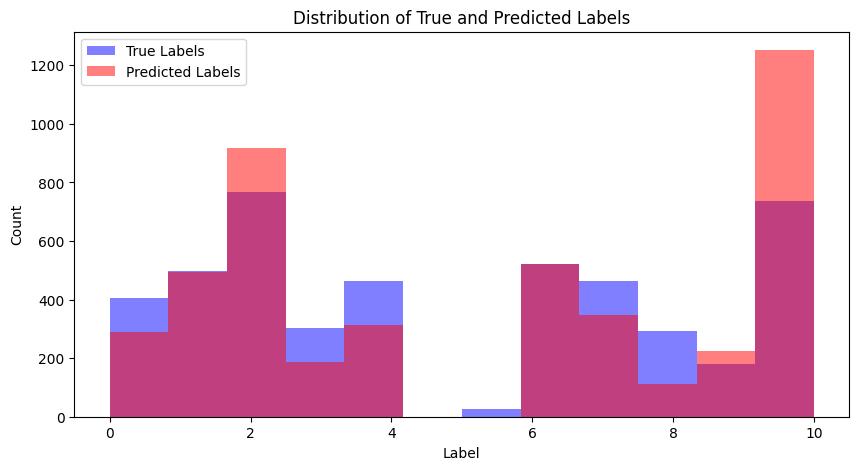

In [ ]:
# print distribution of true labels and predicted labels

plt.figure(figsize=(10, 5))
plt.hist(true_labels, bins=12, alpha=0.5, label='True Labels', color='blue')
plt.hist(predictions, bins=12, alpha=0.5, label='Predicted Labels', color='red')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of True and Predicted Labels')
plt.legend()
plt.show()